In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install pytorch-msssim


In [ ]:
#modified from the code in the paper "A spatiotemporal deep learning model ST-LSTM-SA for hourly rainfall forecasting using radar echo images"
#References:https://www.sciencedirect.com/science/article/pii/S0022169422003237
#References:https://github.com/YukaiDing/STA-LSTM/tree/main
import os
import json
import re
from sympy import false
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pytorch_msssim import ssim
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.models as models

In [ ]:
from task1_package import StormDataset, StormGenerator, get_storm_ids

### 1.Dataloader in all the datasets

In [ ]:
# Set the root directory for storm data
root_dir = '/content/drive/MyDrive/Selected_Storms_curated'

# Initialize the device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the list of storm IDs using the get_storm_ids function
storms = get_storm_ids(root_dir)


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset

root_dir = '/content/drive/MyDrive/Selected_Storms_curated'

train_dataset = StormDataset(root_dir, storm_id=storms, sequence_length=8, split='train')
val_dataset = StormDataset(root_dir, storm_id=storms, sequence_length=8, split='test')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=3)

In [ ]:
next(iter(train_loader))["images"].shape
len(train_dataset)

7429

In [ ]:
storms

['hig',
 'gme',
 'woc',
 'blq',
 'kqu',
 'wsy',
 'ipa',
 'ztb',
 'gkf',
 'qpq',
 'pjj',
 'rml',
 'xjo',
 'vxf',
 'fgi',
 'gic',
 'fna',
 'ing',
 'yfn',
 'ywf',
 'mtw',
 'eoi',
 'sxb',
 'vye',
 'zny',
 'psz',
 'pvj',
 'dzw',
 'ojv',
 'bkh']

### 2.StormGenerator
- CNN + LSTM +DECODER

In [ ]:
model = StormGenerator()

In [ ]:
for batch in train_loader:
  print(batch['images'].shape)
  break

torch.Size([32, 8, 1, 224, 224])


### 3.Train function
- we take 8 pictures in one shifted window, use the front five to pridict the 8th.

In [ ]:
from pytorch_msssim import ssim
import torch
import matplotlib.pyplot as plt

def train(model, train_loader, optimizer, device):
    model.train()  # Set the model to training mode
    loss_history = []
    for epoch in range(num_epochs):
        total_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            images = batch['images'].to(device)


            input_images = images[:, :5, :, :, :]  # Use the first five images as input sequence
            target_image = images[:, 7, :, :, :].squeeze(1)  # Use the 8th image as target
            target_image = target_image.unsqueeze(1)

            optimizer.zero_grad()

            predicted_image = model(input_images)

            # Calculate loss using SSIM
            loss = 1 - ssim(predicted_image, target_image, data_range=1, size_average=True)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)  # Store the average loss for this epoch

        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

    # Plot the training loss
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()


Epoch [1/50], Average Loss: 0.4792
Epoch [2/50], Average Loss: 0.4100
Epoch [3/50], Average Loss: 0.4037
Epoch [4/50], Average Loss: 0.3997
Epoch [5/50], Average Loss: 0.3964
Epoch [6/50], Average Loss: 0.3936
Epoch [7/50], Average Loss: 0.3920
Epoch [8/50], Average Loss: 0.3899
Epoch [9/50], Average Loss: 0.3887
Epoch [10/50], Average Loss: 0.3875
Epoch [11/50], Average Loss: 0.3866
Epoch [12/50], Average Loss: 0.3854
Epoch [13/50], Average Loss: 0.3846
Epoch [14/50], Average Loss: 0.3837
Epoch [15/50], Average Loss: 0.3832
Epoch [16/50], Average Loss: 0.3820
Epoch [17/50], Average Loss: 0.3814
Epoch [18/50], Average Loss: 0.3803
Epoch [19/50], Average Loss: 0.3793
Epoch [20/50], Average Loss: 0.3786
Epoch [21/50], Average Loss: 0.3778
Epoch [22/50], Average Loss: 0.3772
Epoch [23/50], Average Loss: 0.3765
Epoch [24/50], Average Loss: 0.3757
Epoch [25/50], Average Loss: 0.3744
Epoch [26/50], Average Loss: 0.3740
Epoch [27/50], Average Loss: 0.3729
Epoch [28/50], Average Loss: 0.3723
E

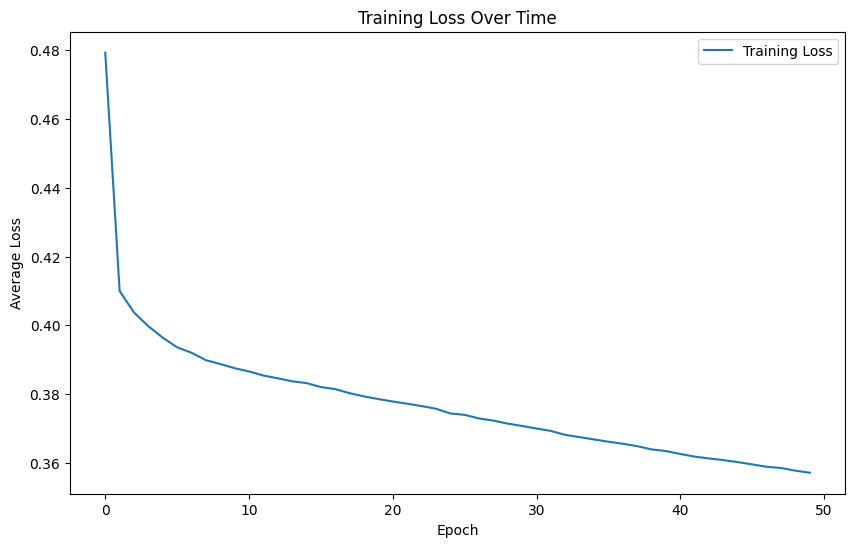

In [ ]:
#SSIM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StormGenerator().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
train(model, train_loader, optimizer, device)

### 4.Save the model
- after the training, we need to save the model as pth so we can be able to reuse the parameters.

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/surprise_storm_50epoch_85to1_ssim0.26_model.pth')

### 5.Evaluation function

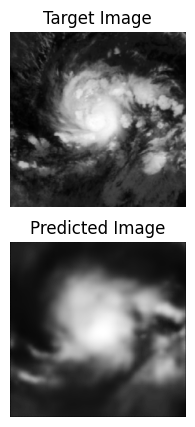

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def eval(model, data_loader, device):
    # we can choose to use the model parameters which we already trained.
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model = StormGenerator().to(device)
    # model.load_state_dict(torch.load('/content/drive/MyDrive/surprise_storm_100_ssim0.25_model.pth'))
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            images = batch['images'].to(device)


            input_images = images[:, :5, :, :, :]  # Use the first five images as input sequence
            target_image = images[:, 7, :, :, :].squeeze(1)  # Use the 8th image as target

            # Generate prediction
            predicted_image = model(input_images)

            if batch_idx == 0:  # Just show the first batch
                fig, axs = plt.subplots(2, 1, figsize=(10, 5))

                # Show target image
                axs[0].set_title('Target Image')
                axs[0].imshow(target_image[0].cpu().numpy(), cmap='gray')
                axs[0].axis('off')

                # Show predicted image
                axs[1].set_title('Predicted Image')
                axs[1].imshow(predicted_image[0].squeeze().cpu().numpy(), cmap='gray')
                axs[1].axis('off')

                plt.show()
                break  # only show one set of images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

eval(model, val_loader, device)



### 6.Predict in the surprise dataset.

In [ ]:
surprise_dir = '/content/drive/MyDrive/Surprise_Storm/'
surprise_storm = ['tst']
surprise_dataset = StormDataset(surprise_dir, storm_id=surprise_storm, sequence_length=8, split='train')
surprise_loader = DataLoader(surprise_dataset, batch_size=1, shuffle=False, num_workers=3)
print(len(surprise_loader))

195


torch.Size([1, 8, 1, 224, 224])
Saved predicted image 1 at /content/drive/MyDrive/Yolanda_generatedimages_85to1/tst252.jpg
Saved predicted image 2 at /content/drive/MyDrive/Yolanda_generatedimages_85to1/tst253.jpg
Saved predicted image 3 at /content/drive/MyDrive/Yolanda_generatedimages_85to1/tst254.jpg


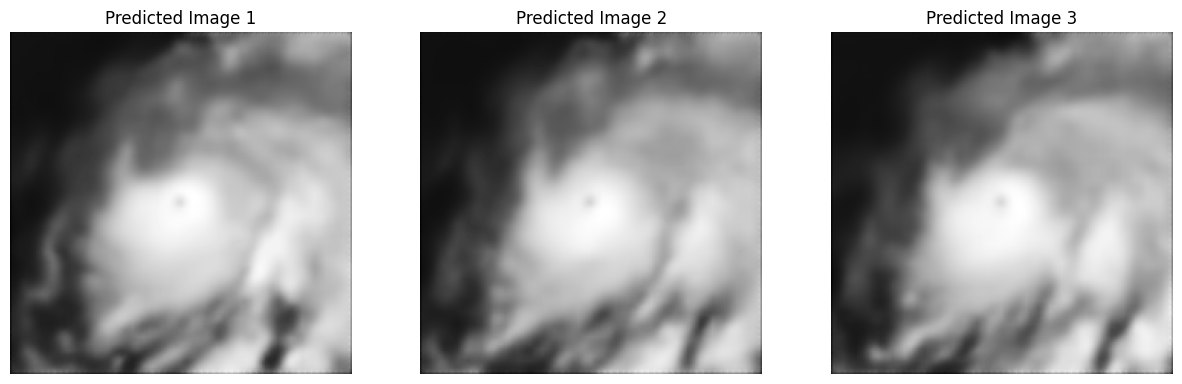

In [ ]:
def eval_continuous_prediction(model, data_loader, device, start_batch=1, num_predictions=3):

    # we can use the model we trained before.
    # model = StormGenerator().to(device)
    # model.load_state_dict(torch.load('/content/drive/MyDrive/surprise_storm_100_ssim0.25_model.pth'))
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            images = batch['images'].to(device)


            input_sequence = images[:, :5, :, :, :]
            iter = 5
            predicted_images = []
            for _ in range(num_predictions):
                # Generate prediction for the next image
                predicted_image = model(input_sequence)
                predicted_images.append(predicted_image)
                input_sequence = torch.cat((input_sequence[:, 1:, :, :, :], images[:,iter , :, :, :].unsqueeze(1)), dim=1)
                iter += 1
            if batch_idx == start_batch:  # Show and save images for the start_batch
                print(batch['images'].shape)
                # Display and save predicted images
                fig, axs = plt.subplots(1, num_predictions, figsize=(15, 5))
                for i in range(num_predictions):

                    # Show predicted image
                    axs[i].set_title(f'Predicted Image {i+1}')
                    predicted_img = predicted_images[i][0].squeeze().cpu().numpy()
                    axs[i].imshow(predicted_img, cmap='gray')
                    axs[i].axis('off')

                    # Save predicted image
                    save_path = f'/content/drive/MyDrive/Yolanda_generatedimages_85to1/tst{i+252}.jpg'
                    plt.imsave(save_path, predicted_img, cmap='gray')
                    print(f'Saved predicted image {i+1} at {save_path}')

                plt.show()
                break
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

eval_continuous_prediction(model, surprise_loader, device,start_batch = 194)